In [56]:
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

image202.jpg


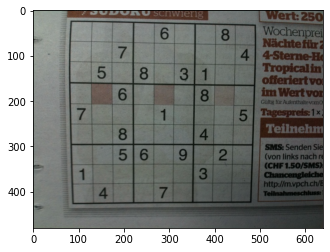

In [131]:
folder = "data/training"

img_list = []
for file_name in os.listdir(folder):
    if file_name.endswith(".jpg"):
        img_list.append(file_name)


a = random.choice(img_list)
print(a)
puzzle_a = cv2.imread(folder + "/" + a)
plt.figure()
plt.imshow(puzzle_a)
plt.show()

In [73]:
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import numpy as np
import imutils
import cv2

In [114]:
def find_puzzle(image, debug = False):

    # convert the image to greyscale and apply a slight blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 3)

    # apply adapative thresholding and then invert threshold map
    thresh = cv2.adaptiveThreshold(blurred, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh = cv2.bitwise_not(thresh)

    # check to see if we are visualizing each step of the image
    # processing pipeline (debug mode)
    if debug:
        cv2.imshow("Puzzle Threshold", thresh)
        cv2.waitKey(0)

    # find contours in the threshold image and sort by size in desc order
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)

    # initialize a contour that corresponds to the puzzle outline
    puzzleCnt = None

    # loop over the contours
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        if len(approx) == 4:
            puzzleCnt = approx
            break

    # if the puzzle contour is empty than our script could not find
    # the outline of the puzzle, so raise an error
    if puzzleCnt is None:
        raise Exception(("Could not find puzzle outline, try debugging thresholding and contour steps."))

    # check to see if debug mode is enabled, and continue showing processing pipeline results
    if debug:
        output = image.copy()
        cv2.drawContours(output, [puzzleCnt], -1, (0, 255, 0), 2)
        cv2.imshow("Puzzle Outline", output)
        cv2.waitKey(0)

    # apply a four point perspective transform to both the original
    # image and greyscale image to obtain a top-down view of the puzzle
    puzzle = four_point_transform(image, puzzleCnt.reshape(4, 2))
    warped = four_point_transform(gray, puzzleCnt.reshape(4, 2))

    # check for debug status
    if debug:
        cv2.imshow("Puzzle Transform", puzzle)
        cv2.waitKey(0)

    # return a 2-tuple of puzzle in both RGB and grayscale
    return (puzzle, warped)

In [115]:
# extracting digits from cleaned image
def extract_digit(cell, debug = False):
    # apply autmatic thresholding to the cell and then clear any
    # connected borders that touch the border of the cell
    thresh = cv2.threshold(cell, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)

    # check for debug status
    if debug:
        cv2.imshow("Cell Thresh", thresh)
        cv2.waitKey(0)

    # find contours in the thresholded cell
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
	# if no contours were found than this is an empty cell
    if len(cnts) == 0:
	    return None
	
    # otherwise, find the largest contour in the cell and create a
	# mask for the contour
    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)

    # compute the percentage of masked pixels relative to the total
    # area of the image
    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)

    # if less than 3% of the mask is filled, then we are looking
    # at noise and can safely ignore the contour
    if percentFilled < 0.03:
        return None

    # apply the mask to the thresholded cell
    digit = cv2.bitwise_and(thresh, thresh, mask = mask)

    # check for debug status
    if debug:
        cv2.imshow("Digit", digit)
        cv2.waitKey(0)

    # return the digit to the calling function
    return digit

In [132]:
(puzzle_image, warped) = find_puzzle(puzzle_a, debug = True)

In [117]:
board = np.zeros((9, 9), dtype = "int")

stepX = warped.shape[1] // 9
stepY = warped.shape[0] // 9

cellLocs = []

In [119]:
for y in range(0, 9):
    row = []

    for x in range(0, 9):
        startX = x * stepX
        startY = y * stepY
        endX = (x + 1) * stepX
        endY = (y + 1) * stepY

        row.append((startX, startY, endX, endY))

        cell = warped[startY:endY, startX:endX]
        digit = extract_digit(cell, debug = True)

        if digit is not None:
            roi = cv2.resize(digit, (28, 28))
            roi = roi.astype("float") / 255.0
            #roi = img_to_array(roi)
            roi = np.expand_dims(roi, axis = 0)

    cellLocs.append(row)